# Exercise Sheet 2: ICA2: Noise & Kurtosis
Machine Intelligence 2<br>
SS 2017, Obermayer/Augustin/Guo<br>
due: **2017-06-14**<br>
Group: Outlaws (Muhammed Cengizhan Özmen, Zhanwang Chen, Sedat Koca, Huajun Li, Khaled Mansour)

<small>*Used Python version 2.7.11 (https://www.continuum.io/downloads, http://ipython.org/install.html)*</small>

## 6.1 * Natural Gradient*

In [8]:
# imports
import os
from scipy.io.wavfile import write
from IPython.core.display import HTML, display
from __future__ import division
from matplotlib import style
style.use("ggplot")


import scipy as sp
import numpy as np
import pylab as plt
#import pandas as pd
import warnings
# play functions in iPython notebook
try:
    from IPython.display import Audio
    def wavPlayer(data, rate):
        display(Audio(data, rate=rate))
except ImportError:
    pass

In [9]:
s1 = np.fromfile('sound1.dat', dtype=float, sep='\n')
s2 = sp.fromfile('sound2.dat', dtype=float, sep='\n')

s = sp.stack((s1, s2))

A = sp.random.randint(1, high=11, size=4)
A = A.reshape((2,2))
A = A + sp.eye(2)

W_true = sp.linalg.inv(A)

x = sp.dot(A, s)
sp.io.wavfile.write('mixed1' + '.wav', 8192, x[0,:])

idx = sp.random.permutation(18000)
x_shuffled = x[: , idx]



In [10]:
#Center the data to zero mean
x_mean = sp.mean(x_shuffled, axis=1).reshape((x.shape[0], 1))

# center shuffled data
x_shuffled_centered = x_shuffled - x_mean

# center unshuffled data
x_centered = x - x_mean

#Initialize the unmixing matrix W with random values
W = sp.random.randint(1, high=2, size=4)
W = W.reshape((2,2)) * 0.1
W = W + sp.eye(2) * 0.1

**Step 2** Compute the update matrix $∆W$ using the natural gradient 

$$
\Delta W = \epsilon \ \frac{\partial e}{\partial W} \ W^T W
$$

In [11]:
#Implement a matrix version of the ICA learning algorithm.
def ICA_natural_gradient(W, x):
    gradient = sp.concatenate((sp.dot(W, x), sp.dot(W, x)), axis=1)
    gradient = sp.special.expit(gradient) * 2
    gradient = sp.ones((gradient.shape)) - gradient
    gradient = gradient * x.flatten()
    normalization = sp.dot(W.T, W)
    gradient = sp.dot(gradient, normalization)
    return gradient

In [12]:
def ICA(W, x, n=0.01, method='natural'):
    vals = []
    t = 1
    
    for _ in range(2):
            for i in range(x.shape[1]):
                # adaptive learning rate !? --> bad results and not wanted
                rate = n #/ t
                
                # select random datapoint
                #idx = sp.random.randint(0, high=18000, size=1)
                #datapoint = x[:, idx].reshape((2,1))
                
                # choose next datapoint
                datapoint = x[:, i].reshape((2,1))
                
                gradient = 0
                if method == 'natural':
                    gradient = ICA_natural_gradient(W, datapoint)
                    W = W + rate * gradient
                
                if (t % 1000) == 0:
                    val = sp.sum((rate * gradient) ** 2)
                    vals.append(val)
                
                t = t + 1
    return W, vals

def unmix_sources(W, x):
    return sp.dot(W, x)

# for unshuffled data
W_natural, vals_natural = ICA(sp.copy(W), x_centered, method='natural')
s_natural = unmix_sources(W_natural, x_centered)

# for shuffled data
W_natural_shuffled, vals_natural_shuffled = ICA(sp.copy(W), x_shuffled_centered, method='natural')
s_natural_shuffled = unmix_sources(W_natural_shuffled, x)

for i in range(10):
    W_natural_shuffled, vals_natural_shuffled = ICA(sp.copy(W), x_shuffled_centered, method='natural')

s_natural_shuffled_iteration = unmix_sources(W_natural_shuffled, x)

In [13]:
def plot_and_play_data(data, title, label1, label2):
    sp.io.wavfile.write(label1 + '.wav', 8192, data[0, :])
    sp.io.wavfile.write(label2 + '.wav', 8192, data[1, :])
    print(label1 + ':')
    wavPlayer(data[0, :], 8192)
    print(label2 + ':')
    wavPlayer(data[1, :], 8192)
# plot data
    x_axis = sp.arange(data.shape[1])
    
    plt.figure()
    plt.plot(x_axis, data[1,:], 'b-', label=label2, alpha=0.5)
    plt.plot(x_axis, data[0,:], 'r-', label=label1, alpha=0.5)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    plt.grid(True)
    plt.xlabel('time')
    plt.ylabel('sound')
    plt.title(title)
    plt.show()

sound 1:


sound 2:


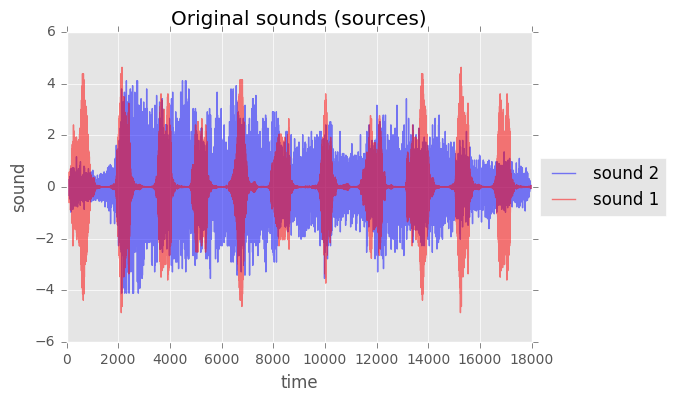

In [14]:
# the original sources
plot_and_play_data(s, 'Original sounds (sources)', 'sound 1', 'sound 2')

observation 1:


observation 2:


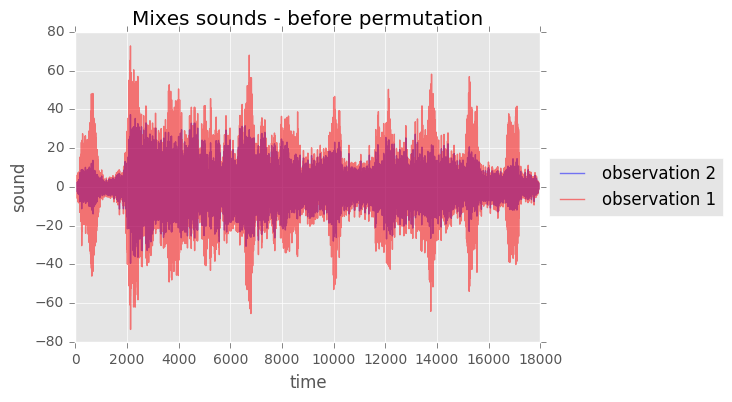

In [15]:
# Play the mixed sources before the data permutation
plot_and_play_data(x, 'Mixes sounds - before permutation', 'observation 1', 'observation 2')

source 1 (natural estim.):


source 2 (natural estim.):


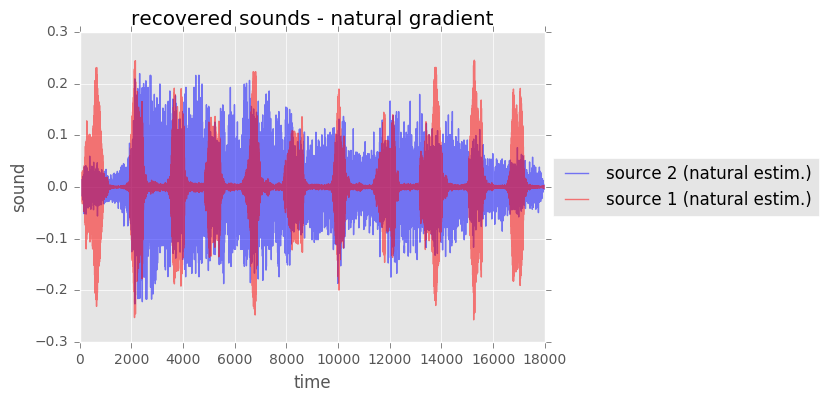

In [18]:
#(a)
# Play the recovered signals using the unpermuted data
plot_and_play_data(s_natural, 'recovered sounds - natural gradient', 'source 1 (natural estim.)', 'source 2 (natural estim.)')

source 1 shuffled (natural estim.):


source 2 shuffled (natural estim.):


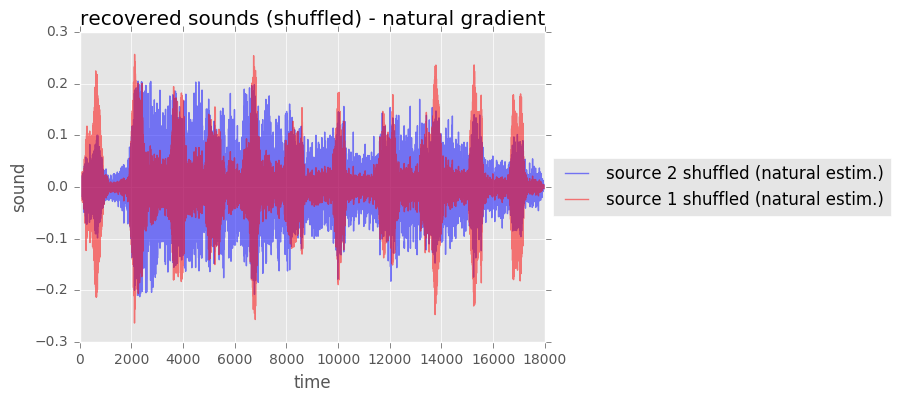

In [17]:
# Play the recovered signals using the unpermuted data
plot_and_play_data(s_natural_shuffled, 'recovered sounds (shuffled) - natural gradient', 'source 1 shuffled (natural estim.)', 'source 2 shuffled (natural estim.)')

source 1 shuffled (natural estim.):


source 2 shuffled (natural estim.):


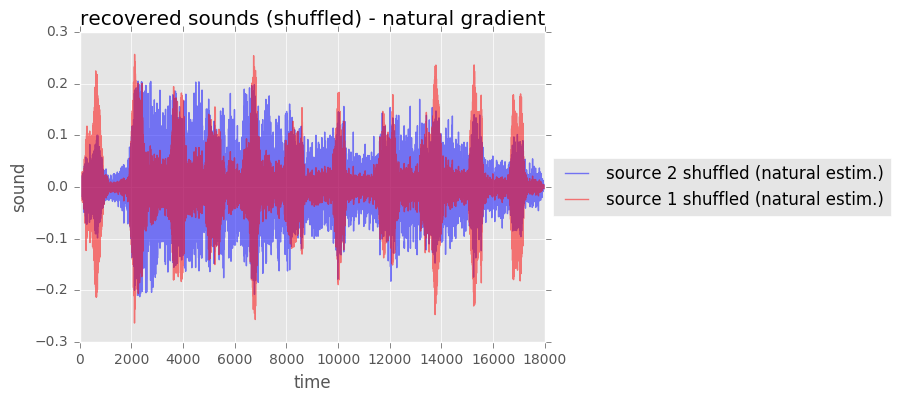

In [19]:
# Play the recovered signals using the unpermuted data after Iteration
plot_and_play_data(s_natural_shuffled_iteration, 'recovered sounds (shuffled) - natural gradient', 'source 1 shuffled (natural estim.)', 'source 2 shuffled (natural estim.)')

In [20]:
noise = sp.random.normal(0,0.001,[18000])

sp.io.wavfile.write('noise' + '.wav', 8192, x[0,:])


In [21]:
#Mixing with two original sources
s_mix = sp.stack((s1,s2,noise))

A:
[[ 7.  4.  6.]
 [ 6.  6.  9.]
 [ 5.  7.  6.]]
W_true:
[[  3.33333333e-01  -2.22222222e-01   9.03917214e-18]
 [ -1.11111111e-01  -1.48148148e-01   3.33333333e-01]
 [ -1.48148148e-01   3.58024691e-01  -2.22222222e-01]]
-0.0123456790123
observation 1 (shuffled):


observation 2 (shuffled):


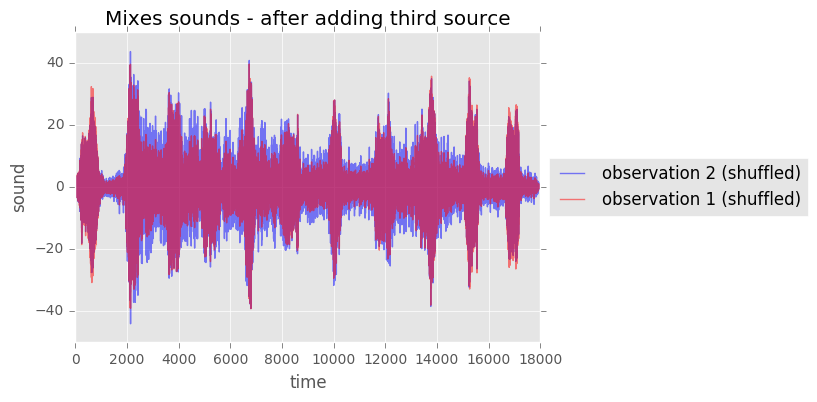

In [22]:
A = sp.random.randint(1, high=11, size=9)
A = A.reshape((3,3))
A = A + sp.eye(3)

# compute true W
W_true = sp.linalg.inv(A)

print('A:')
print(A)
print('W_true:')
print(W_true)
print(sp.linalg.det(W_true))

x_new = sp.dot(A, s_mix)
sp.io.wavfile.write('mixed_3' + '.wav', 8192, x[0,:])
# Play the mixed sources
plot_and_play_data(x_new, 'Mixes sounds - after adding third source', 'observation 1 (shuffled)', 'observation 2 (shuffled)')


In [23]:
#Center the new data to zero mean
idx = sp.random.permutation(18000)
x_new_shuffled = x_new[: , idx]
x_new_mean = sp.mean(x_new_shuffled, axis=1).reshape(x_new.shape[0],1)

# center shuffled data
x_shuffled_centered = x_new_shuffled - x_new_mean

# center unshuffled data
x_new_centered = x_new - x_new_mean

W = sp.random.randint(1, high=2, size=4)
W = W.reshape((2,2)) * 0.1
W = W + sp.eye(2) * 0.1

W_natural, vals_natural = ICA(sp.copy(W), x_new_centered, method='natural')
s_natural = unmix_sources(W_natural, x_new_centered)

# Plot & Play the recovered sources
plot_and_play_data(s_natural, 'recovered sounds - natural gradient', 'source 1 (natural estim.)', 'source 2 (natural estim.)')

ValueError: total size of new array must be unchanged

## 6.2 *Moments of univariate distributions*

### Laplace distribution

**Probability density function**:

\begin{align}
p(x) = \frac{1}{2b}e^{-\frac{|x-\mu|}{b}}
\end{align}

**Moment generating function**:

\begin{align}
M_X(t) &= \mathbb{E}\left[e^{tX}\right] \\
&= \int_{-\infty}^{\infty}e^{sx}p(x)dx \\
&= \frac{1}{2b}\int_{-\infty}^{\infty}e^{sx}e^{-\frac{|x-\mu|}{b}}dx \\
\end{align}

Using the Fourier transform of the exponential function:

\begin{equation}
\mathcal{F}_X\left[e^{-2\pi k_0 |x|}\right](k) = \frac{1}{\pi}\frac{k_0}{k^2 + k_0^2}
\end{equation}

gives

\begin{equation}
M_X(t) = \frac{e^{\mu t}}{1 - b^2t^2}
\end{equation}


**Mean: first moment**
\begin{align}
\langle X \rangle &= \frac{dM_X(t)}{dt}\Bigr|_{t=0} \\
&= \frac{(\mu e^{\mu t})(1-t^2b^2) - e^{\mu t}(-2tb^2)}{(1-t^2b^2)^2}\Bigr|_{t=0}\\
&= \frac{(\mu \cdot 1)(1 - 0) - 0}{(1-0)^2}\\
&= \mu
\end{align}

**Variance: second centered moment**

First, we take the 2nd derivative of the moment generating function $M_X(t)$ w.r.t $t$ to obtain the 2nd raw moment $\langle X^2\rangle$:

\begin{align}
\langle X^2 \rangle &= \frac{d^2M_X(t)}{dt^2}\Bigr|_{t=0} \\
&= \frac{((\mu^2e^{\mu t})(1-t^2b^2) + (\mu e^{\mu t})(-2tb^2) - (\mu e^{\mu t}(-2tb^2)+e^{\mu t}(-2b^2))(1-t^2b^2)^2 - ((\mu e^{\mu t})(1-t^2b^2) - e^{\mu t}(-2tb^2))(-4b^2t + 4b^4t^3)}{(1-2b^2t^2 + t^4b^4)^2}\Bigr|_{t=0}\\
&= \frac{((\mu^2 \cdot 1)(1-0) + 0 - (0 - 2b^2))(1-0)^2-((\mu \cdot 1)(1-0) - 0)(0 + 0))}{(1-0+0)^2}\\
&= \mu^2 + 2b^2
\end{align}

From that the 2nd centered moment is derived as follows:

\begin{align}
\langle X^2 \rangle_c &= \langle (X-\langle X \rangle)^2\rangle\\
&= \langle X^2 \rangle - (\langle X \rangle)^2\\
&= \mu^2 + 2b^2 - \mu^2\\
&= 2b^2
\end{align}

**Skewness: third standardized moment** $\langle X^3 \rangle_s$

First, we take the 3nd derivative of the moment generating function $M_X(t)$ w.r.t $t$ to obtain the 3rd raw moment $\langle X^3\rangle$:

\begin{align}
\langle X^3 \rangle &= \frac{d^2M_X(t)}{dt^2}\Bigr|_{t=0}& \\
&= \dots&\text{(full derivative omitted for readability)}\\
&= 6 \mu b^2 + \mu^3
\end{align}

Then we calculate the 3rd centered moment

\begin{align}
\langle X^3 \rangle_c &= \langle(X - \mu)^3\rangle&\\
&= \langle X^3 \rangle - 3 \mu \langle X^2 \rangle + 3 \mu^2 \langle X \rangle - \mu^3 &\text{linearity of expected value}\\
&= \langle X^3 \rangle - 3 \mu \langle X^2 \rangle + 2 \mu^3 &\text{$\langle X \rangle = \mu$}\\
&= \langle X^3 \rangle - 6 \mu b^2 - \mu^3 &\text{$\langle X^2 \rangle = 2b^2$}\\
&= 6 \mu b^2 + \mu^3 - 6 \mu b^2 - \mu^3 &\text{$\langle X^3 \rangle = 6 \mu b^2 + \mu^3$}\\
&= 0
\end{align}

From which follows the skewness of the laplace distribution $\langle X^3\rangle_s = \frac{\langle X^3 \rangle_c}{(2b^2)^{\frac{3}{2}}} = 0$.

**Kurtosis: fourth standardized moment** $\langle X^4 \rangle_s$

First, we take the 4th derivative of the moment generating function $M_X(t)$ w.r.t $t$ to obtain the 4th raw moment $\langle X^4\rangle$:

\begin{align}
\langle X^4 \rangle &= \frac{d^4M_X(t)}{dt^4}\Bigr|_{t=0} \\
&= \dots&\text{(full derivative omitted for readability)}\\
&= 6\sigma^4 + 12\mu^2 b^2 - 7\mu^4
\end{align}

Then we calculate the 4rd centered moment

\begin{align}
\langle X^4 \rangle_c &= \langle(X - \mu)^4\rangle&\\
&= \langle X^4 \rangle - 4\langle X^3 \rangle\mu + 6\langle X^2 \rangle\mu^2 - 4\langle X \rangle\mu^3 + \mu^4 &\text{linearity of expected value}\\
&= 6\sigma^4 + 12\mu^2 b^2 - 7\mu^4 - 24\mu^2 b^2 + 4\mu^4 + 6\mu^4 + 12\mu^2 b^2 - 4\mu^4 + \mu^4&\text{$\langle X^4 \rangle, \langle X^3 \rangle, \langle X^2 \rangle, \langle X \rangle$}\\\\
&= 6\sigma^4
\end{align}

From which follows the kurtosis of the laplace distribution $\langle X^4\rangle_s = \frac{\langle X^4 \rangle_c}{\sigma^4} = 6$.

### Gaussian distribution

**Probability density function**:

\begin{align}
p(x) &= \frac{1}{\sqrt{2\pi \sigma^2}}e^{\frac{-(x-\mu)}{2\sigma^2}}
\end{align}

**Moment generating function**:
\begin{align}
M_X(t) &= \langle e^{tX} \rangle \\
&= \int_{-\infty}^{\infty} \frac{e^{tx}}{\sqrt{2\pi \sigma^2}}e^{\frac{-(x-\mu)}{2\sigma^2}}dx\\
&= e^{\mu t + \sigma^2 \frac{t^2}{2}}\\
&:= \phi(t)
\end{align}

In all following equations we substitute $e^{\mu t + \sigma^2 \frac{t^2}{2}}$ for $\phi(t)$ for simplicity.

**Mean: first moment**
\begin{align}
\langle X \rangle &= \frac{dM_X(t)}{dt}\Bigr|_{t=0} \\
&= (\mu + \sigma^2 t)\phi(t)\Bigr|_{t=0}\\
&=(\mu + 0) \cdot 1\\
&= \mu
\end{align}

**Variance: second centered moment**

First, we take the 2nd derivative of the moment generating function $M_X(t)$ w.r.t $t$ to obtain the 2nd raw moment $\langle X^2\rangle$:

\begin{align}
\langle X^2 \rangle &= \frac{d^2M_X(t)}{dt^2}\Bigr|_{t=0} \\
&= \sigma^2 \phi(t)+\phi(t)(\mu + t \sigma^2)^2\Bigr|_{t=0}\\
&= \sigma^2 e^0 + e^0(\mu + 0)^2\\
&= \sigma^2 + \mu^2
\end{align}

From that the 2nd centered moment is derived as follows:

\begin{align}
\langle X^2 \rangle_c &= \langle (X-\langle X \rangle)^2\rangle\\
&= \langle X^2 \rangle - (\langle X \rangle)^2\\
&= \sigma^2 + \mu^2 - \mu^2\\
&= \sigma^2
\end{align}

**Skewness: third standardized moment**

First, we take the 3rd derivative of the moment generating function $M_X(t)$ w.r.t $t$ to obtain the 3rd raw moment $\langle X^3\rangle$:

\begin{align}
\langle X^3 \rangle &= \frac{d^3M_X(t)}{dt^3}\Bigr|_{t=0} \\
&= (\mu + t \sigma^2) \sigma^2 \phi(t) + \phi(\mu + t \sigma^2)^3 + \phi(t) 2\sigma^2 (\mu + t \sigma^2) \Bigr|_{t=0}\\
&= (\mu + t\sigma^2)\phi\left[(\mu + t\sigma^2)^2 + 3\sigma^2\right] \Bigr|_{t=0}\\
&= (\mu + 0)\left[(\mu + 0)^2 + 3\sigma^2\right]\\
&= 3\sigma^2 \mu + \mu^3
\end{align}

Then we calculate the 3rd centered moment

\begin{align}
\langle X^3 \rangle_c &= \langle(X - \mu)^3\rangle&\\
&= \langle X^3 \rangle - 3 \mu \langle X^2 \rangle + 3 \mu^2 \langle X \rangle - \mu^3 &\text{linearity of expected value}\\
&= \langle X^3 \rangle - 3 \mu \langle X^2 \rangle + 2 \mu^3 &\text{$\langle X \rangle = \mu$}\\
&= \langle X^3 \rangle - 3 \mu\sigma^2 - \mu^3 &\text{$\langle X^2 \rangle = \sigma^2 + \mu^2$}\\
&= 3\sigma^2 \mu + \mu^3 - 3 \mu\sigma^2 - \mu^3 &\text{$\langle X^3 \rangle = \sigma^2 + \mu^2$}\\
&= 0
\end{align}

From which follows the skewness of the gaussian distribution $\langle X^3\rangle_s = \frac{\langle X^3 \rangle_c}{\sigma^3} = 0$.

**Kurtosis: fourth standardized moment**

First, we take the 4th derivative of the moment generating function $M_X(t)$ w.r.t $t$ to obtain the 4th raw moment $\langle X^4\rangle$:

\begin{align}
\langle X^4 \rangle &= \frac{d^4M_X(t)}{dt^4}\Bigr|_{t=0} \\
&= 3\sigma^2(\mu + t\sigma^2)^2 \phi + 3\sigma^4 \phi + \phi(\mu + t\sigma^2)^4 + 3\sigma^2\phi(\mu + t\sigma^2)^2\Bigr|_{t=0}\\
&= 3\sigma^2\mu^2 + 3\sigma^4 + \mu^4 + 3\sigma^2\mu^2\\
&= 6\sigma^2\mu^2 + 3\sigma^4 + \mu^4
\end{align}

Then we calculate the 4rd centered moment

\begin{align}
\langle X^4 \rangle_c &= \langle(X - \mu)^4\rangle&\\
&= \langle X^4 \rangle - 4\langle X^3 \rangle\mu + 6\langle X^2 \rangle\mu^2 - 4\langle X \rangle\mu^3 + \mu^4 &\text{linearity of expected value}\\
&= 6\sigma^2\mu^2 + 3\sigma^4 + \mu^4 - 4\mu(3\sigma^2\mu + \mu^3) + 6\mu^2(\sigma^2 + \mu^2) - 4\mu^4 + \mu^4 &\text{$\langle X^4 \rangle, \langle X^3 \rangle, \langle X^2 \rangle, \langle X \rangle$}\\
&= 6\sigma^2\mu^2 + 3\sigma^4 - 12\sigma^2\mu^2 - 4\mu^4 + 6\mu^2\sigma^2 + 6\mu^4 - 2\mu^4\\
&= 3\sigma^4
\end{align}

From which follows the kurtosis of the gaussian distribution $\langle X^4\rangle_s = \frac{\langle X^4 \rangle_c}{\sigma^4} = 3$.

### Uniform distribution

**Probability density function**:

\begin{align}
p(x) &=
\begin{cases}
\frac{1}{b-a} & \text{for }a \leq x \leq b\\
0 & \text{for } x < a \text{ or } x > b
\end{cases}
\end{align}

**Moment generating function**:
\begin{align}
M_X(t) &= \langle e^{tx} \rangle \\
&= \int_a^b \frac{e^{tx}}{b-a}dx \\
&= \left[ \frac{e^{tx}}{t(b-a)} \right]^b_a \\
&= \begin{cases}
\frac{e^{tb} - e^{ta}}{t(b-a)} & \text{for }t \neq 0\\
1 & \text{for } t = 0
\end{cases}
\end{align}

**Mean: first moment**
Unfortunately, the moment generating function is not differentiable at t=0 but we can approximate the first raw moment with $\lim_{t\rightarrow 0}$:

\begin{align}
\langle X \rangle &= \int_{-\infty}^{\infty}\frac{H(x-a) - H(x-b)}{b-a}xdx\\
&= \int_{a}^{b}\frac{x}{b-a}dx\\
&= \left[\frac{x^2}{2(b-a)}\right]_a^b\\
&= \frac{b^2 - a^2}{2(b-a)}\\
&= \frac{1}{2}(a+b)
\end{align}

**Variance: second centered moment**

With the first raw moment, we derive the $n$-th centered moment analytically:

\begin{align}
\langle X^n \rangle_c &= \int_{-\infty}^{\infty}\frac{H(x-a) - H(x-b)}{b-a}[x-\mu_1']^ndx\\
&=\int_{-\infty}^{\infty}\frac{H(x-a) - H(x-b)}{b-a}[x-\frac{1}{2}(a+b)]^ndx\\
&= \int_{a}^{b}\frac{[x-\frac{1}{2}(a+b)]^n}{b-a}dx\\
% TODO add more here
&= \frac{(a-b)^n + (b-a)^n}{2^{n+1}(n+1)}\\
\end{align}

Which gives

\begin{align}
\langle X^2 \rangle_c &= \frac{1}{12}(b-a)^2\\
\end{align}

**Skewness: third standardized moment**

From the formula for the n-th centered moment it follows that $\langle X^3 \rangle_c = 0$. And hence the third standardized moment

\begin{align}
\langle X^3 \rangle_s &= \frac{\langle X^3 \rangle_c}{\langle X^2\rangle_c^{\frac{3}{2}}}\\
&= \frac{0}{(\frac{1}{12}(b-a)^2)^{\frac{3}{2}}}\\
&= 0
\end{align}


**Kurtosis: fourth standardized moment**

From the formula for the n-th centered moment it follows that $\langle X^4 \rangle_c = \frac{1}{80}(b-a)^4$. The fourth standardized moment is then

\begin{align}
\langle X^4 \rangle_s &= \frac{\langle X^4 \rangle_c}{\langle X^2\rangle_c^{\frac{4}{2}}}\\
&= \frac{\frac{1}{80}(b-a)^4}{(\frac{1}{12}(b-a)^2)^2}\\
&= \frac{\frac{1}{80}(b-a)^4}{\frac{1}{144}(b-a)^4}\\
&= \frac{9}{5}
\end{align}

Which results in the following table:

\begin{equation}
\begin{array}{rccc}
 & Laplace (\mu, b) & Gauss (\mu, \sigma) & Uniform (a, b) \\ \hline
Mean & \mu & \mu & \frac{1}{2}(a+b) \\ \hline
Variance & 2 b^2 & \sigma^2 & \frac{1}{12}(b-a)^2  \\ \hline
Skewness & 0 & 0  & 0  \\ \hline
Kurtosis & 6 & 3  & \frac{9}{5}  \\ \hline
\end{array}
\end{equation}

## 6.3 *Kurtosis of Toy Data*

In [1]:
import sys
print(sys.version)
import IPython
import scipy.io
import numpy as np
import math
import pylab as plt
%matplotlib inline 

2.7.12 |Anaconda custom (64-bit)| (default, Jul  2 2016, 17:42:40) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


In [2]:
#Task 6.3

#Importing three datasets from distrib.mat file...
distrib = scipy.io.loadmat('distrib.mat')
uniform = distrib['uniform']
normal = distrib['normal']
laplacian = distrib['laplacian']

#Task 6.3.a

#Creating a numpy matrix A given and converting three datasets
#to again numpy matrices to handle easily
A = np.matrix([[4, 3],[2, 1]])
uniform = np.matrix(uniform)
normal = np.matrix(normal)
laplacian = np.matrix(laplacian)

#Get the products
mix_uniform = A * uniform
mix_normal = A * normal
mix_laplacian = A * laplacian

#Task 6.3.b

#Centering three datasets
mix_uniform_centered = mix_uniform - np.mean(mix_uniform)
mix_normal_centered = mix_normal - np.mean(mix_normal)
mix_laplacian_centered = mix_laplacian - np.mean(mix_laplacian)

#Task 6.3.c

#Covariance matrices
mix_uni_centered_cov = np.cov(mix_uniform_centered)
mix_norm_centered_cov = np.cov(mix_normal_centered)
mix_lap_centered_cov = np.cov(mix_laplacian_centered)

#Eigen-values and eigen-vectors
eig_val_uni, eig_vec_uni = np.linalg.eig(mix_uni_centered_cov)
eig_val_norm, eig_vec_norm = np.linalg.eig(mix_norm_centered_cov)
eig_val_lap, eig_vec_lap = np.linalg.eig(mix_lap_centered_cov)

#Projection to the eigen vector
uni_proj = eig_vec_uni * mix_uniform_centered
norm_proj = eig_vec_norm * mix_normal_centered 
lap_proj = eig_vec_lap * mix_laplacian_centered 


In [3]:
print uniform.shape
print uni_proj.shape

(2, 10000)
(2, 10000)


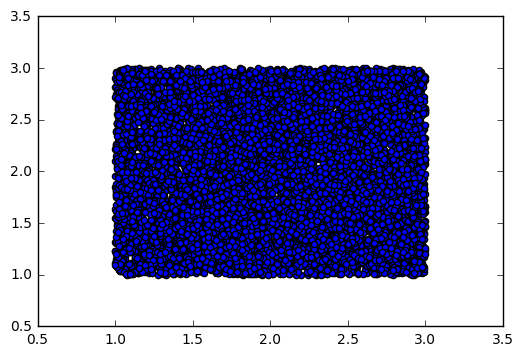

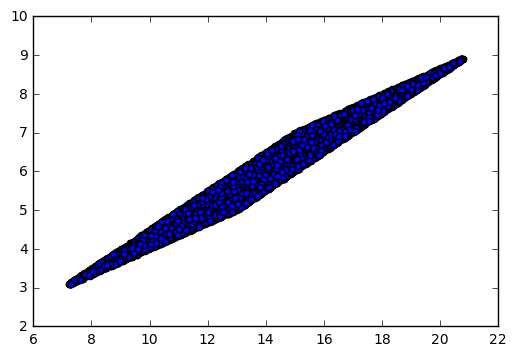

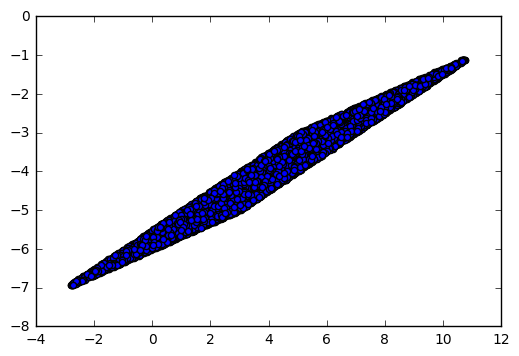

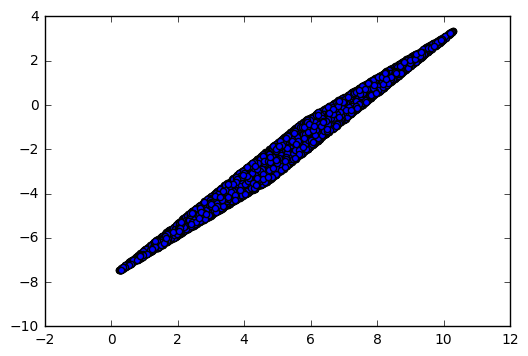

In [4]:

plt.scatter(uniform[0,:],uniform[1,:],label='uniform')
plt.show()
plt.scatter(mix_uniform[0,:],mix_uniform[1,:],label='mix_uniform')
plt.show()
plt.scatter(mix_uniform_centered[0,:],mix_uniform_centered[1,:],label='mix_uniform_centered')
plt.show()

plt.scatter(uni_proj[0,:],uni_proj[1,:],label='uni_proj')
plt.show()

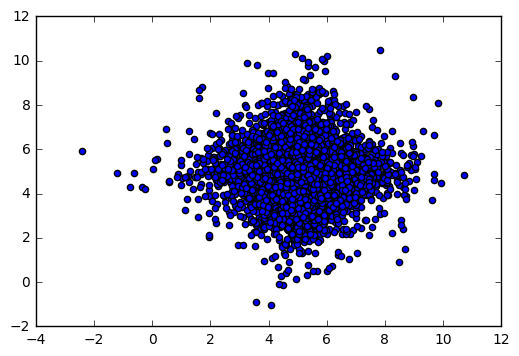

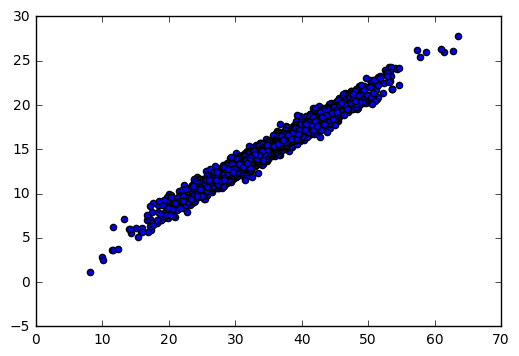

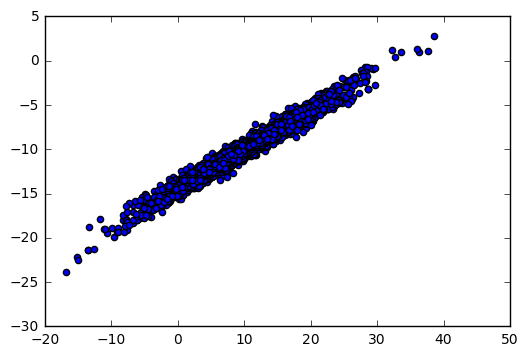

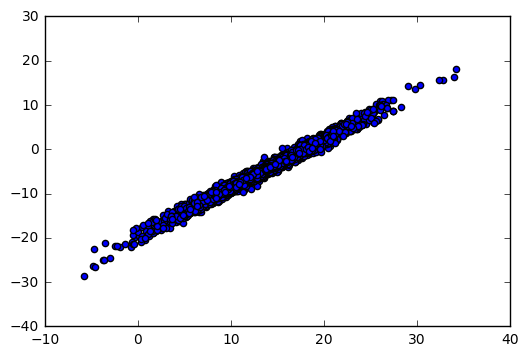

In [5]:

plt.scatter(laplacian[0,:],laplacian[1,:],label='laplacian')
plt.show()
plt.scatter(mix_laplacian[0,:],mix_laplacian[1,:],label='mix_laplacian')
plt.show()

plt.scatter(mix_laplacian_centered[0,:],mix_laplacian_centered[1,:],label='mix_laplacian_centered')
plt.show()

plt.scatter(lap_proj[0,:],lap_proj[1,:],label='lap_proj')
plt.show()

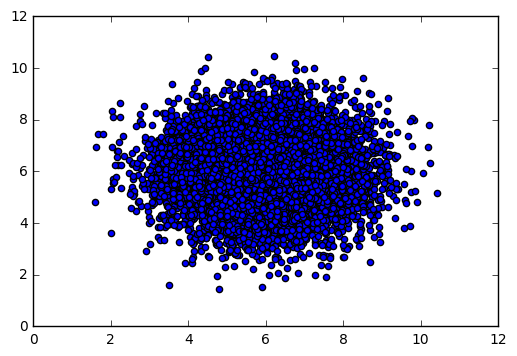

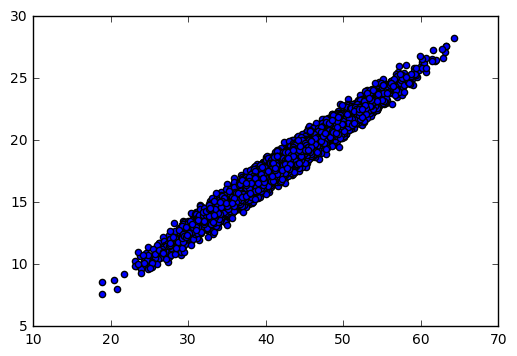

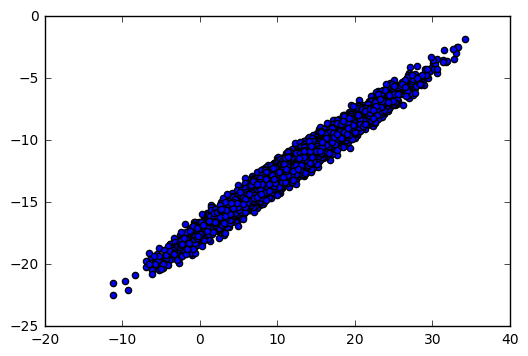

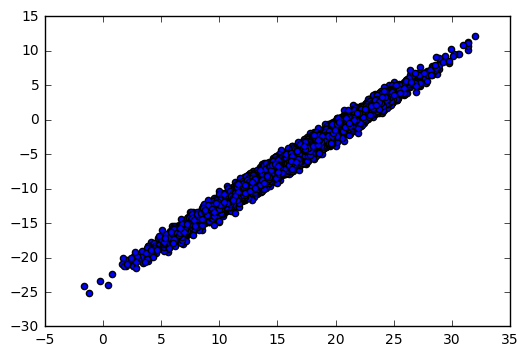

In [6]:
plt.scatter(normal[0,:],normal[1,:],label='normal')
plt.show()
plt.scatter(mix_normal[0,:],mix_normal[1,:],label='mix_normal')
plt.show()
plt.scatter(mix_normal_centered[0,:],mix_normal_centered[1,:],label='mix_normal_centered')
plt.show()

plt.scatter(norm_proj[0,:],norm_proj[1,:],label='norm_proj')
plt.show()